In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os

In [2]:
plt_vis = False

In [3]:
# фунцкия поиска лок минимума функции
def golden_section_search(func, min_val, max_val, eps, *args):
    golden_ratio = (1 + 5 ** 0.5) / 2  # Золотое сечение

    a = min_val
    b = max_val

    while abs(b - a) > eps:
        x1 = b - (b - a) / golden_ratio
        x2 = a + (b - a) / golden_ratio

        f1 = func(x1, *args)
        f2 = func(x2, *args)

        if f1 < f2:
            b = x2
        else:
            a = x1

    return (a + b) / 2

In [4]:
def get_first_frame(filepath = 'frame_0.png'):
    video = cv2.VideoCapture(pjoin('..','..','Test1 - alecsandr27000.mkv'))
    _, frame_0 = video.read()
    plt.imshow(frame_0)
    plt.show()
    # np.save('frame_0.npy', frame0)
    video.release()
    del video
    cv2.imwrite(filepath, frame_0)
    # plt.axis('off')  # Отключение отображения осей
    # plt.xlim(0, frame_0.shape[0])  # Определение границы оси x
    # plt.ylim(0, frame_0.shape[1])  # Определение границы оси y
    # plt.gca().invert_yaxis()  # Инвертирование оси y для совпадения с конвенцией изображений
    # plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=300)  # Сохранение изображения
    # plt.show()
    return frame_0

In [5]:
def low_clip_value(x, low = -np.inf):
    return max(x, low)

In [6]:
def clip_value(x, low = -np.inf, high = np.inf):
    return min(max(x, low), high)

In [7]:
def create_np_template(diam = 256, rot_angle = 0, filename = None):

    # Создание черно-белого изображения
    np_template = np.ones((diam, diam), dtype=np.uint8)*255

    # Определение цветов для секторов
    colors = [255, 0]  # белый, чёрный

    # Определение размеров секторов
    outer_radius = diam // 2
    inner_radius = diam // 4

    # Определение угловых градусов для секторов
    angles = np.array([0, 90, 180, 270]) - rot_angle

    # Рисование чередующихся секторов
    for i, angle in enumerate(angles):
        start_angle = angle
        end_angle = angle + 90
        color = colors[i % 2]
        cv2.ellipse(np_template, (outer_radius, outer_radius), (outer_radius, outer_radius), 0, start_angle, end_angle, color, -1)

    # Рисование внутренних секторов
    for i, angle in enumerate(angles):
        start_angle = angle
        end_angle = angle + 90
        color = colors[(i + 1) % 2]
        cv2.ellipse(np_template, (outer_radius, outer_radius), (inner_radius, inner_radius), 0, start_angle, end_angle, color, -1)

    # Преобразование в черно-белую картинку-массив numpy
    return np.array(np_template, dtype=np.uint8)

In [8]:
def calc_diff(a, b, mask = None, reduction='MEAN'):
    if mask:
        if reduction == 'MEAN':
            return (((a - b)**2)*mask).sum() / mask.sum()
        else:#if reduction == 'SUM':
            return (((a - b)**2)*mask).sum()
    else:
        if reduction == 'MEAN':
            return ((a - b)**2).mean()
        else:#if reduction == 'SUM':
            return ((a - b)**2).sum()

In [9]:
def fill_out_circle(arr):
    np_arr = 255 - np.array(arr)
    radius = np_arr.shape[0] // 2
    cv2.ellipse(np_arr, (radius, radius), (radius, radius), 0, 0, 360, 0, -1)
    return arr + np_arr

In [10]:
class MarkOnImage:
    def __init__(self, x_pos = 255., y_pos = 255., diam = 255., rot_angle = 0.):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.diam = diam
        self.rot_angle = rot_angle
    def get_center(self):
        return (self.x_pos, self.y_pos)

In [11]:
def detect_mark(image):
    # Список для хранения координат кликов
    click_coordinates = []
    image_copy = np.copy(image)

    cv2.namedWindow('Image')

    # Масштабирование изображения для отображения на виджете
    height, width, _ = image.shape
    print(height, width)
    aspect_ratio = width / height
    max_width = 1280
    max_height = 720
    scaled_width = max_width
    scaled_height = max_height
    if width > max_width or height > max_height:
        if aspect_ratio > 1:
            scaled_width = max_width
            scaled_height = int(max_width / aspect_ratio)
        else:
            scaled_height = max_height
            scaled_width = int(max_height * aspect_ratio)
    
    scaled_image = cv2.resize(image, (scaled_width, scaled_height))
    
    scaled_image_copy = scaled_image.copy()
    # Функция обработки событий мыши
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:  # Если была нажата левая кнопка мыши
            # global click_coordinates
            # global scaled_image_copy
            click_coordinates.append((x, y))  # Добавляем координаты клика в список
            cv2.circle(scaled_image_copy, (x, y), 3, (0, 255, 0), -1)  # Рисуем круг на месте клика
    click_coordinates = []

    # Установка функции обратного вызова для событий мыши
    cv2.setMouseCallback('Image', mouse_callback)

    while True:
        # Отображение изображения
        cv2.imshow('Image', scaled_image_copy)
        # Ожидание нажатия клавиши "Esc" или "Enter" для выхода
        if cv2.waitKey(1) == 27 or cv2.waitKey(1) == 13:
            break

    click_coordinates = np.array(click_coordinates)*1.
    print()
    click_coordinates[:,0] *= (height / scaled_height)
    click_coordinates[:,1] *= (width / scaled_width)

    center = click_coordinates.mean(axis=0)

    if plt_vis:
        # Отображение мест кликов
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for coordinate in click_coordinates:
            plt.plot(coordinate[0], coordinate[1], 'ro')

        plt.plot(center[0], center[1], 'bo')
        plt.title('Результаты нажатия мышью')
        plt.show()

    # Закрытие окна
    cv2.destroyAllWindows()
    # определение центра квадрата
    click_coordinates = np.array(click_coordinates)
    click_coordinates
    rad = int(max(((click_coordinates - center)**2).sum(axis=1)**0.5))
    center = center.astype(int)
    if plt_vis:
        image_copy = image.copy()
        print(image_copy.shape)
        # cv2.namedWindow('Image')
        cv2.circle(image_copy, center, rad, (0, 255, 255), -1)
        plt.imshow(image_copy)
        plt.title('Выбранная окрестность')
        plt.show()
    # cv2.imshow('Image', image_copy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Удаление большей части фона
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mark_part = image_gray[center[1] - rad:center[1] + rad, center[0] - rad:center[0] + rad]
    label_pos_x, label_pos_y = center[0] - rad, center[1] - rad

    mark_part = fill_out_circle(mark_part)
    if plt_vis:
        plt.imshow(mark_part)
        plt.title('Удаление большей части фона')
        plt.show()

    # Распознование контрастных точек
    ret, thresh = cv2.threshold(mark_part, 170, 255, 0)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    thresh = 255 - thresh
    contours_image, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if plt_vis:
        plt.imshow(thresh)
        plt.title('Распознование контрастных точек')
        plt.show()

    # Распознавание контура круглой метки
    part_area = mark_part.shape[0]*mark_part.shape[1]
    min_area_lim = part_area / 12
    max_area_lim = part_area * 0.9
    best_cntr = contours_image[0]
    best_cntr_area = cv2.contourArea(best_cntr)
    for cntr in contours_image:
        area = cv2.contourArea(cntr)
        if area > min_area_lim and area < max_area_lim:
            if (area > best_cntr_area):
                best_cntr = cntr
                best_cntr_area = area
            cntr_np = np.array(cntr).reshape(-1, 2)

    if plt_vis:
        fig, ax = plt.subplots(1,3, figsize=(18,6))
        # ax[0].imshow(mark_part)
        ax[0].imshow(mark_part)
        ax[1].imshow(np.zeros_like(mark_part))
        ax[2].imshow(np.zeros_like(mark_part))
        best_cntr_np = np.array(best_cntr).reshape(-1, 2)
        ax[0].plot(best_cntr_np[:,0], best_cntr_np[:,1])
        ax[1].plot(best_cntr_np[:,0], best_cntr_np[:,1])
        ax[2].fill(best_cntr_np[:,0], best_cntr_np[:,1])
        fig.suptitle('Распознавание расположения круглой метки')
        plt.show()

    # Квадрат, описывающий метку
    x,y,w,h = cv2.boundingRect(best_cntr)
    wh_mean = (w + h) // 2
    dx = (w - wh_mean) // 2
    dy = (h - wh_mean) // 2
    if plt_vis:
        plt.imshow(mark_part[y + dy:y + dy + wh_mean, x + dx:x + dx + wh_mean])
        plt.title('Найденная метка')
        plt.show()

    # Координаты угла метки
    label_pos_x += x + dx
    label_pos_y += y + dy
    if plt_vis:
        image_copy = image.copy()
        cv2.rectangle(image_copy, (label_pos_x, label_pos_y), (label_pos_x + wh_mean, label_pos_y + wh_mean), (36,255,12), 2)
        plt.imshow(image_copy)
    # cv2.imshow('Image', image_copy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # Вырез метки с картинки
    detected_template = image_gray[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean]
    ret, thresh = cv2.threshold(detected_template, 170, 255, 0)

    # Задаем интервал значений и точность
    min_val = 0
    mean_val = 90
    max_val = 180
    eps = 0.1

    # Вызываем быстрый поиск для функции func полученной от calc_diff
    func = lambda grad_val, thr: calc_diff(thr,create_np_template(diam=wh_mean,rot_angle=grad_val))
    result_1 = golden_section_search(func, min_val, mean_val, eps, thresh)
    result_2 = golden_section_search(func, mean_val, max_val, eps, thresh)
    # print("Значение угла, при котором достигается минимум ошибки в первой половине:", result_1)
    val_1 = func(result_1, thresh)
    # print("Минимальное значение ошибки:", val_1)
    # print("Значение угла, при котором достигается минимум ошибки во второй половине:", result_2)
    val_2 = func(result_2, thresh)
    # print("Минимальное значение ошибки:", val_2)
    result = result_1 if val_1 <= val_2 else result_2
    val = min(val_1, val_2)
    # print('______________________')
    # print("Значение угла, при котором достигается минимум ошибки:", result)
    # print("Минимальное значение ошибки:", val)
    most_acc_template = create_np_template(diam=wh_mean,rot_angle=result)
    # print(f'Координаты метки: ({label_pos_y},{label_pos_x})')
    # print(f'Угол поворота метки: {result}')
    if plt_vis:
        image_copy = image.copy()
        image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 0] = 255
        image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 1] = most_acc_template
        image_copy[label_pos_y:label_pos_y + wh_mean,label_pos_x:label_pos_x + wh_mean, 2] = 255
        # cv2.imshow('Result',image_copy)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.imshow(image_copy)
        plt.title(f'Координаты метки: ({label_pos_y + wh_mean//2}, {label_pos_x + wh_mean//2})\nУгол поворота метки: {result}')
        plt.show()
    return MarkOnImage(label_pos_x + wh_mean//2, label_pos_y + wh_mean//2, wh_mean, result)

In [12]:
image_name = 'frame_0.png'
images_dir = 'images'
image_path = pjoin(images_dir, image_name)

In [13]:
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
if not os.path.exists(image_path):
    get_first_frame(image_path)

In [14]:
# Загрузка изображения
image = cv2.imread(image_path)

In [15]:
mark1 = detect_mark(image)

1080 1920


In [16]:
mark2 = detect_mark(image)

1080 1920



In [17]:
cv2.waitKey(0)
cv2.destroyAllWindows()

In [65]:
for m in [mark1, mark2]:
    print(f'{m.diam}, {m.x_pos}, {m.y_pos}, {m.rot_angle}')

106, 590, 841, 2.507764050037855
107, 1381, 190, 2.507764050037855


In [66]:
if mark2.x_pos < mark1.x_pos:
    mark1, mark2 = mark2, mark1

In [108]:
# captured TO aligned along axises
capt2algn = np.zeros((2,3))
(_h, _w, _) = image.shape
_mean_a = (mark1.rot_angle + mark2.rot_angle) / 2
_mean_diam = (mark1.diam + mark2.diam) / 2
_cos_a, _sin_a = np.cos(np.deg2rad(_mean_a)), np.sin(np.deg2rad(_mean_a))
_dx, _dy = mark1.x_pos, mark1.y_pos
capt2algn[0,:] = np.array([ _cos_a, -_sin_a, ( -_dx*_cos_a + (_dy)*_sin_a ) ])
capt2algn[1,:] = np.array([ -_sin_a, -_cos_a, ( _dx*_sin_a + (_dy)*_cos_a ) ])

In [109]:
capt2algn

array([[ 9.99042302e-01, -4.37547662e-02, -5.52637200e+02],
       [-4.37547662e-02, -9.99042302e-01,  8.66009888e+02]])

In [138]:
src = image.copy()
warp_dst = cv2.warpAffine(src, capt2algn, (_w, _h))

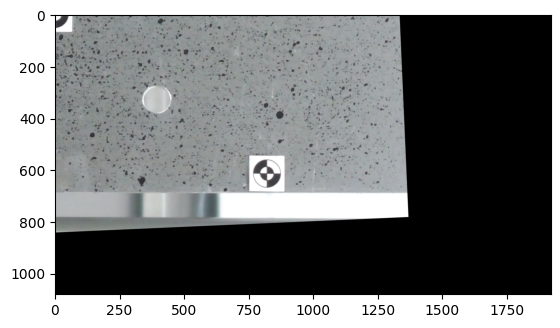

In [139]:
plt.imshow(warp_dst)
plt.show()

In [130]:
print(capt2algn)

[[ 9.99042302e-01 -4.37547662e-02 -5.52637200e+02]
 [-4.37547662e-02 -9.99042302e-01  8.66009888e+02]]


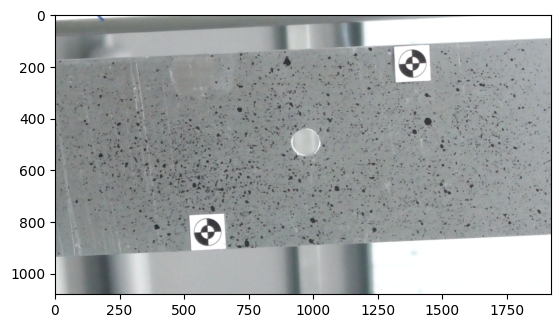

In [131]:
plt.imshow(src)
plt.show()

In [132]:
image_diag = (_h**2 + _w**2)**0.5


In [133]:
m_dist_x, m_dist_y = (capt2algn @ [mark2.x_pos, mark2.y_pos, 1])

In [140]:
left_m_indent = abs(([[1920, 1080, 1], [0, 1080, 1], [1920, 0, 1], [0, 0, 1]] @ capt2algn.T)[:,0].min())

In [149]:
# captured TO inscribed
capt2insc = capt2algn.copy()
capt2insc[:,2] += [left_m_indent, _mean_diam]

In [150]:
src = image.copy()
warp_dst = cv2.warpAffine(src, capt2insc, np.ceil((image_diag, 2*_mean_diam + m_dist_y)).astype(int))

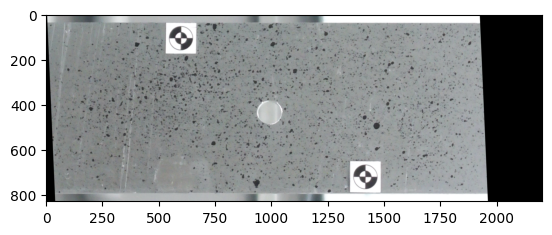

In [151]:
plt.imshow(warp_dst)
plt.show()

In [152]:
mm2pix_ratio = 10. / _mean_diam

In [154]:
# captured TO real mms
capt2real = capt2algn * mm2pix_ratio

In [155]:
capt2real @ [mark2.x_pos, mark2.y_pos, 1]

array([76.87575713, 57.81845242])